# AutoRec for Ranking (Implicit Feedback)

## Motivation

This notebook adapts AutoRec for **implicit feedback** ranking tasks, following the same approach as NCF.

### Key Differences from Rating Prediction:

1. **Data**: Binary interactions (1 = interacted, 0 = not interacted) instead of ratings
2. **Loss**: BCEWithLogitsLoss instead of MSE
3. **Negative Sampling**: Sample negative items during training
4. **Evaluation**: HR@K and NDCG@K (same as NCF)

### Approach:

- Filter ratings >= 4 as positive interactions
- Use negative sampling (NUM_NG negatives per positive)
- Train with binary cross-entropy loss
- Evaluate using HR@K and NDCG@K metrics

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm

# Add src to path
current_dir = os.getcwd()
path = current_dir
while True:
    if os.path.basename(path) == "src":
        if path not in sys.path:
            sys.path.insert(0, path)
        break
    parent = os.path.dirname(path)
    if parent == path:
        break
    path = parent

# Local imports
from utils.model import AutoRec
from utils.autorecdata_implicit import AutoRecImplicitData
from helpers import download_ml1m_dataset
from helpers.ranking_metrics import hit, ndcg
from ncf.utils.ml_to_ncf import preprocess_ml1m_to_ncf_format
from ncf.utils.load_all_data import load_all_data

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

/Users/abbas/Documents/Codes/thesis/recommender/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
# Paths
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), '..', 'data')
MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()), '..', 'models')
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

# Hyperparameters (same as NCF)
LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 50
TOP_K = 10
NUM_HIDDEN_UNITS = 500  # AutoRec specific
EARLY_STOPPING_PATIENCE = 10
NUM_NG = 4  # Number of negatives per positive during training
TEST_NUM_NG = 99  # Number of negatives per positive during testing
LAMBDA_REG = 0.001  # L2 regularization

## Step 1: Preprocess Data for Implicit Feedback

Convert ratings to binary interactions (ratings >= 4 = positive)

In [3]:
# Download and preprocess (exactly same as NCF)
ratings_file = download_ml1m_dataset(DATA_DIR)

# Preprocess to NCF format (filters ratings >= 4, creates train/test split)
train_rating_path, test_rating_path, test_negative_path, user_num, item_num, train_mat = \
    preprocess_ml1m_to_ncf_format(ratings_file, data_dir=DATA_DIR)

# Load data (exactly same as NCF)
train_data, test_data, user_num, item_num, train_mat = load_all_data(
    train_rating_path, test_negative_path
)

✓ Dataset already exists at /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat
✓ Training matrix created: 460225 interactions
Loading training data from /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m.train.rating...
✓ Loaded 460225 training pairs
  - Users: 6038
  - Items: 3533


## Step 2: Create Datasets with Negative Sampling

In [5]:
# Create datasets (exactly same structure as NCF, just using AutoRecImplicitData instead of NCFData)
train_dataset = AutoRecImplicitData(
    train_data,
    item_num,
    train_mat,
    num_ng=NUM_NG,  # From Step 2 configuration
    is_training=True
)

test_dataset = AutoRecImplicitData(
    test_data,
    item_num,
    train_mat,
    num_ng=0,  # No negative sampling for testing
    is_training=False
)


# Create data loaders (exactly same as NCF)
train_loader = data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  
    num_workers=0,  
    pin_memory=True if torch.cuda.is_available() else False 
)

test_loader = data.DataLoader(
    test_dataset,
    batch_size=TEST_NUM_NG + 1,  
    shuffle=False,  
    num_workers=0,  
    pin_memory=True if torch.cuda.is_available() else False
)

## Step 3: Create AutoRec Model

For implicit feedback, we'll use item-based AutoRec and modify it to work with binary data.

In [6]:
# Create item-based AutoRec model
# For implicit feedback, input/output are binary (0 or 1)
model = AutoRec(
    num_users=user_num,
    num_items=item_num,
    num_hidden_units=NUM_HIDDEN_UNITS,
    item_based=True
).to(device)

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(init_weights)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

Model created with 6,044,538 parameters


## Step 4: Evaluation Function

For AutoRec with implicit feedback, we need to:
1. Create a binary interaction matrix from training data
2. Reconstruct item vectors to get predictions
3. Extract user-item scores for ranking

In [10]:
def evaluate_metrics(model, test_loader, top_k, device='cuda', train_mat_tensor=None, batch_group_size=500):
    """
    Optimized evaluation function that batches item reconstructions.
    
    Key optimization: Instead of reconstructing items one batch at a time, we:
    1. Group multiple test batches together
    2. Collect all unique items from the group
    3. Reconstruct them once in a single forward pass
    4. Index into reconstructions for each batch
    
    This reduces forward passes from ~115K to ~230 (with batch_group_size=500).
    
    Args:
        batch_group_size: Number of test batches to process together for batching reconstructions.
                         Larger = fewer forward passes but more memory. Default 500 is a good balance.
    """
    if train_mat_tensor is None:
        raise ValueError("train_mat_tensor is required for AutoRec evaluation")
    
    model.eval() 
    
    HR_list = [] 
    NDCG_list = []
    
    # Convert device string to torch.device for consistency
    if isinstance(device, str):
        if device == 'cuda' and torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
    
    total_batches = len(test_loader)
    
    with torch.no_grad():
        # Collect batches into groups for efficient processing
        batch_group = []
        
        # Use tqdm for progress tracking
        pbar = tqdm(test_loader, desc="Evaluating", leave=False)
        
        for batch_idx, (user, item, label) in enumerate(pbar):
            # Move data to device
            user = user.to(device)
            item = item.to(device)
            
            batch_group.append((user, item, label))
            
            # Process group when it reaches batch_group_size or at the end
            if len(batch_group) >= batch_group_size or batch_idx == total_batches - 1:
                # Collect all unique items from this group
                all_items = torch.cat([b[1] for b in batch_group])
                unique_items = torch.unique(all_items)
                
                # Reconstruct all unique items at once (OPTIMIZATION: single forward pass)
                item_vectors = train_mat_tensor[:, unique_items].T  # Shape: (num_unique, num_users)
                reconstructed_all = model(item_vectors)  # Shape: (num_unique, num_users)
                
                # Create mapping from item ID to reconstruction index
                item_to_idx = {item_id.item(): idx for idx, item_id in enumerate(unique_items)}
                
                # Process each batch in the group
                for user_batch, item_batch, label_batch in batch_group:
                    u = user_batch[0].item()  # All items in batch are for same user
                    batch_size = item_batch.shape[0]
                    
                    # Get reconstruction indices for items in this batch
                    recon_indices = torch.tensor(
                        [item_to_idx[i.item()] for i in item_batch], 
                        device=device, 
                        dtype=torch.long
                    )
                    
                    # Extract predictions for this user (VECTORIZED)
                    predictions = reconstructed_all[recon_indices, u]  # Shape: (batch_size,)
                    
                    # Get top-K
                    _, indices = torch.topk(predictions, min(top_k, batch_size))
                    recommends = torch.take(item_batch, indices).cpu().numpy().tolist()
                    
                    # Ground truth is first item
                    gt_item = item_batch[0].item()
                    
                    try:
                        HR_list.append(hit(gt_item, recommends))
                        NDCG_list.append(ndcg(gt_item, recommends))
                    except Exception as e:
                        HR_list.append(0)
                        NDCG_list.append(0)
                
                # Update progress bar
                processed = min(batch_idx + 1, total_batches)
                pbar.set_postfix({'processed': f'{processed}/{total_batches}'})
                
                # Clear the group
                batch_group = []
    
    try:
        mean_HR = np.mean(HR_list)
        mean_NDCG = np.mean(NDCG_list)
    except Exception as e:
        print(f"Error calculating mean: {e}")
        mean_HR = 0
        mean_NDCG = 0
    
    return mean_HR, mean_NDCG

## Step 5a: Performance Optimizations

This notebook uses several optimizations to speed up training:

1. **Batched Item Vector Reconstruction**: Instead of reconstructing item vectors one-by-one, we batch all unique items in a batch and reconstruct them together
2. **Vectorized Indexing**: Uses PyTorch advanced indexing instead of Python loops
3. **Pre-computed Training Matrix**: Training matrix is converted to dense tensor once and reused
4. **Progress Tracking**: tqdm progress bars and detailed timing logs to identify bottlenecks

## Step 5: Training Loop

Train AutoRec with:
- Binary cross-entropy loss (BCEWithLogitsLoss)
- Negative sampling
- L2 regularization

In [11]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0)

# Create binary training matrix for reconstruction
print("="*60)
print("Preparing training matrix...")
print("="*60)
matrix_start = time.time()
train_mat_tensor = torch.FloatTensor(train_mat.toarray()).to(device)
matrix_time = time.time() - matrix_start
print(f"✓ Training matrix created in {matrix_time:.2f}s (shape: {train_mat_tensor.shape})")

# Training variables
best_hr = 0.0
best_ndcg = 0.0
patience_counter = 0
history = {'loss': [], 'hr': [], 'ndcg': []}

print("="*60)
print("Training AutoRec for Ranking (Implicit Feedback)")
print(f"Total batches per epoch: {len(train_loader)}")
print("="*60)

for epoch in range(EPOCHS):
    model.train()
    epoch_start = time.time()
    
    # Generate negative samples for this epoch (exactly same as NCF)
    train_dataset.ng_sample()
    
    total_loss = 0
    num_batches = 0
    
    # Timing variables
    forward_time = 0
    backward_time = 0
    data_time = 0
    
    # Use tqdm for progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for batch_idx, (user, item, label) in enumerate(train_loader_tqdm):
        batch_start = time.time()
        
        user = user.to(device)
        item = item.to(device)
        label = label.float().to(device)
        
        data_time += time.time() - batch_start
        
        optimizer.zero_grad()
        
        # OPTIMIZED: Batch item vector reconstructions
        forward_start = time.time()
        
        # Get unique items in this batch to avoid redundant reconstructions
        unique_items = torch.unique(item)
        batch_size = user.shape[0]
        
        # Reconstruct all unique item vectors at once (batched)
        item_vectors = train_mat_tensor[:, unique_items].T  # Shape: (num_unique_items, num_users)
        reconstructed_batch = model(item_vectors)  # Shape: (num_unique_items, num_users)
        
        # Create mapping from item to its reconstruction
        item_to_idx = {item_id.item(): idx for idx, item_id in enumerate(unique_items)}
        
        # Extract predictions for each (user, item) pair (VECTORIZED)
        # Create index tensor more efficiently
        recon_indices = torch.tensor([item_to_idx[i.item()] for i in item], device=device, dtype=torch.long)
        predictions = reconstructed_batch[recon_indices, user]  # Vectorized indexing
        
        forward_time += time.time() - forward_start
        
        # Binary cross-entropy loss
        loss = criterion(predictions, label)
        
        # L2 regularization
        l2_reg = 0.0
        l2_reg += torch.sum(model.encoder[0].weight ** 2)
        l2_reg += torch.sum(model.decoder[0].weight ** 2)
        loss = loss + (LAMBDA_REG / 2.0) * l2_reg
        
        backward_start = time.time()
        loss.backward()
        optimizer.step()
        backward_time += time.time() - backward_start
        
        total_loss += loss.item()
        num_batches += 1
        
        # Update progress bar
        if num_batches > 0:
            avg_loss_so_far = total_loss / num_batches
            elapsed_batch = time.time() - epoch_start
            batches_per_sec = num_batches / elapsed_batch if elapsed_batch > 0 else 0
            train_loader_tqdm.set_postfix({
                'loss': f'{avg_loss_so_far:.4f}',
                'speed': f'{batches_per_sec:.1f} b/s'
            })
    
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    epoch_elapsed = time.time() - epoch_start
    
    # Evaluate (pass pre-computed tensor to avoid recreating)
    print(f"  Evaluating on test set ({len(test_loader)} batches)...")
    eval_start = time.time()
    hr, ndcg_score = evaluate_metrics(model, test_loader, TOP_K, device, train_mat_tensor)
    eval_time = time.time() - eval_start
    print(f"  Evaluation completed in {eval_time:.1f}s")
    
    total_elapsed = time.time() - epoch_start
    history['loss'].append(avg_loss)
    history['hr'].append(hr)
    history['ndcg'].append(ndcg_score)
    
    # Early stopping
    if hr > best_hr:
        best_hr = hr
        best_ndcg = ndcg_score
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, 'AutoRec-Ranking.pth'))
        marker = " *"
    else:
        patience_counter += 1
        marker = ""
    
    # Track best NDCG separately (may not coincide with best HR)
    if ndcg_score > best_ndcg:
        best_ndcg = ndcg_score
    
    # Detailed timing breakdown
    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Loss: {avg_loss:.4f} | "
          f"HR@{TOP_K}: {hr:.4f} | NDCG@{TOP_K}: {ndcg_score:.4f} | "
          f"Time: {total_elapsed:.1f}s{marker}")
    print(f"  Timing: Forward={forward_time:.1f}s, Backward={backward_time:.1f}s, "
          f"Data={data_time:.1f}s, Eval={eval_time:.1f}s")
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("\n" + "="*60)
print(f"Best HR@{TOP_K}: {best_hr:.4f}")
print(f"Best NDCG@{TOP_K}: {best_ndcg:.4f}")
print("="*60)

Preparing training matrix...
✓ Training matrix created in 0.08s (shape: torch.Size([6038, 3533]))
Training AutoRec for Ranking (Implicit Feedback)
Total batches per epoch: 8989
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (115056 batches)...


  Evaluation completed in 26.6s
Epoch 01/50 | Loss: 0.5158 | HR@10: 0.5407 | NDCG@10: 0.3116 | Time: 182.0s *
  Timing: Forward=45.2s, Backward=91.5s, Data=0.4s, Eval=26.6s
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (115056 batches)...


  Evaluation completed in 26.2s
Epoch 02/50 | Loss: 0.5061 | HR@10: 0.5396 | NDCG@10: 0.3111 | Time: 181.4s
  Timing: Forward=45.3s, Backward=91.7s, Data=0.4s, Eval=26.2s
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (115056 batches)...


  Evaluation completed in 26.5s
Epoch 03/50 | Loss: 0.5028 | HR@10: 0.5398 | NDCG@10: 0.3114 | Time: 185.3s
  Timing: Forward=46.2s, Backward=93.4s, Data=0.4s, Eval=26.5s
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (115056 batches)...


  Evaluation completed in 26.8s
Epoch 04/50 | Loss: 0.5013 | HR@10: 0.5374 | NDCG@10: 0.3101 | Time: 186.6s
  Timing: Forward=46.6s, Backward=94.4s, Data=0.4s, Eval=26.8s
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (115056 batches)...


  Evaluation completed in 26.9s
Epoch 05/50 | Loss: 0.5006 | HR@10: 0.5348 | NDCG@10: 0.3093 | Time: 190.6s
  Timing: Forward=47.4s, Backward=96.9s, Data=0.4s, Eval=26.9s
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (115056 batches)...


  Evaluation completed in 27.1s
Epoch 06/50 | Loss: 0.5002 | HR@10: 0.5358 | NDCG@10: 0.3095 | Time: 186.5s
  Timing: Forward=46.4s, Backward=94.5s, Data=0.4s, Eval=27.1s
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (115056 batches)...


  Evaluation completed in 26.7s
Epoch 07/50 | Loss: 0.5000 | HR@10: 0.5337 | NDCG@10: 0.3085 | Time: 188.2s
  Timing: Forward=47.0s, Backward=96.0s, Data=0.4s, Eval=26.7s
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (115056 batches)...


  Evaluation completed in 26.7s
Epoch 08/50 | Loss: 0.4999 | HR@10: 0.5339 | NDCG@10: 0.3089 | Time: 186.7s
  Timing: Forward=46.4s, Backward=94.3s, Data=0.4s, Eval=26.7s
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (115056 batches)...


  Evaluation completed in 26.6s
Epoch 09/50 | Loss: 0.4995 | HR@10: 0.5355 | NDCG@10: 0.3099 | Time: 185.1s
  Timing: Forward=46.3s, Backward=93.8s, Data=0.4s, Eval=26.6s
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (115056 batches)...


  Evaluation completed in 26.5s
Epoch 10/50 | Loss: 0.4997 | HR@10: 0.5375 | NDCG@10: 0.3110 | Time: 180.2s
  Timing: Forward=45.2s, Backward=89.9s, Data=0.4s, Eval=26.5s
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (115056 batches)...


  Evaluation completed in 27.7s
Epoch 11/50 | Loss: 0.4995 | HR@10: 0.5357 | NDCG@10: 0.3103 | Time: 183.7s
  Timing: Forward=45.9s, Backward=91.7s, Data=0.4s, Eval=27.7s

Early stopping at epoch 11

Best HR@10: 0.5407
Best NDCG@10: 0.3116


## Step 6: Load Best Model and Final Evaluation

In [12]:
# Load best model
best_model_path = os.path.join(MODEL_PATH, 'AutoRec-Ranking.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("=" * 70)
    print("Loaded best model from checkpoint")
    print("=" * 70)
else:
    print("Best model checkpoint not found. Using current model state.")

# Final evaluation
# Use the pre-computed tensor (or create if needed)
if 'train_mat_tensor' not in globals():
    print("Creating training matrix tensor...")
    train_mat_tensor = torch.FloatTensor(train_mat.toarray()).to(device)

final_hr, final_ndcg = evaluate_metrics(model, test_loader, TOP_K, device, train_mat_tensor)

print("=" * 70)
print("FINAL BEST METRICS")
print("=" * 70)
print(f"Best HR@{TOP_K}: {best_hr:.6f}")
print(f"Best NDCG@{TOP_K}: {best_ndcg:.6f}")
print(f"Final HR@{TOP_K}: {final_hr:.6f}")
print(f"Final NDCG@{TOP_K}: {final_ndcg:.6f}")
print("=" * 70)

Loaded best model from checkpoint


FINAL BEST METRICS
Best HR@10: 0.540728
Best NDCG@10: 0.311600
Final HR@10: 0.540728
Final NDCG@10: 0.311600


## Step 7: Visualize Training Progress

✓ Saved training plots to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/autorec_ranking_training.png


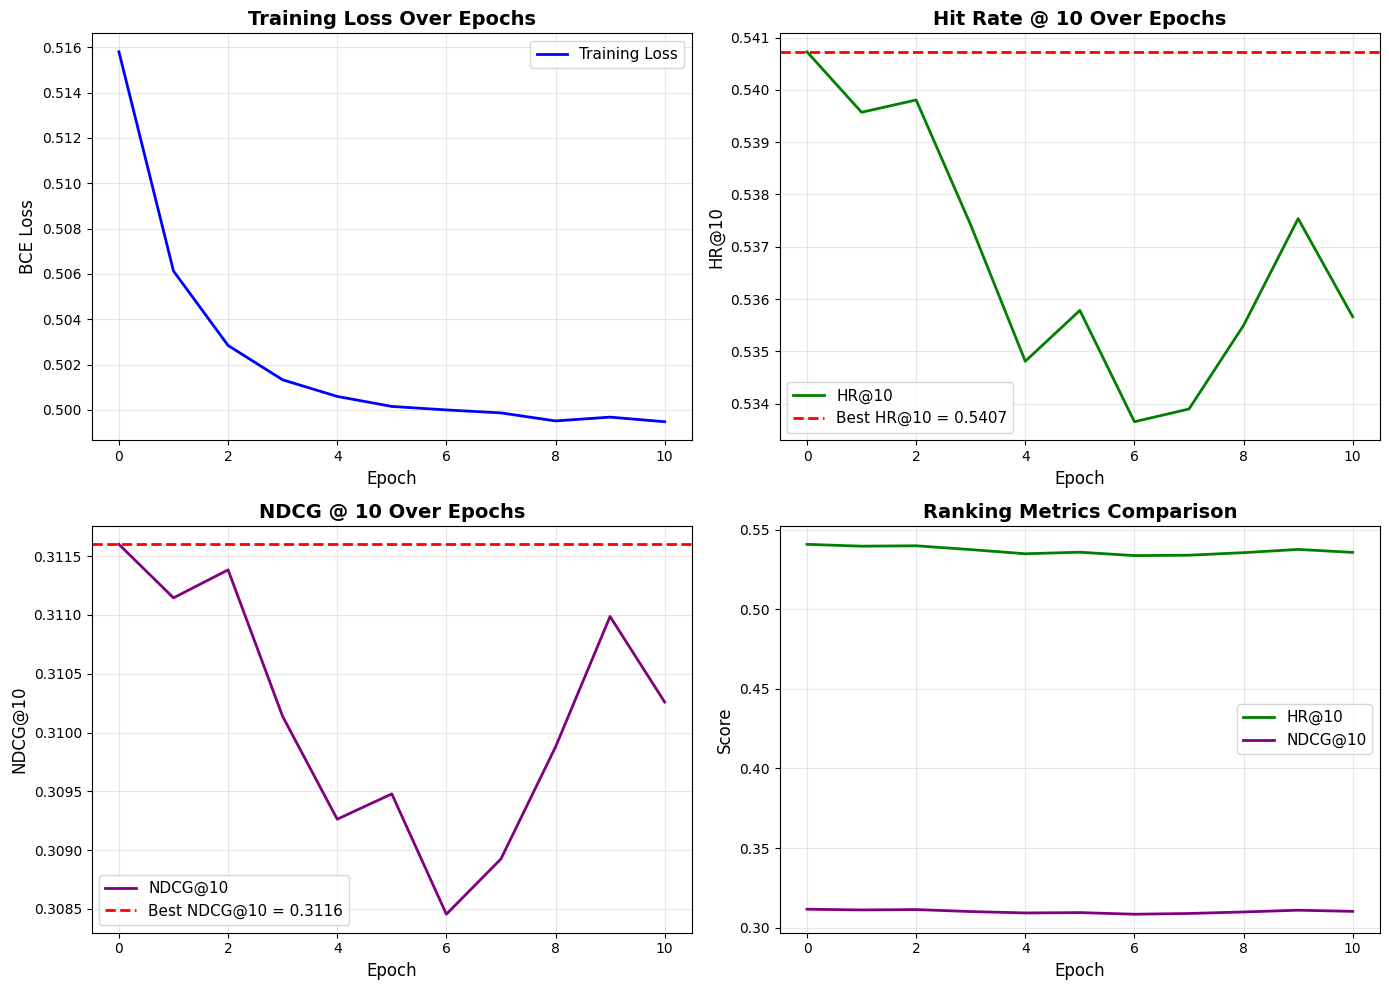

In [13]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = range(len(history['loss']))

# Plot 1: Training Loss
axes[0, 0].plot(epochs, history['loss'], 'b-', linewidth=2, label='Training Loss')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('BCE Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(fontsize=11)

# Plot 2: HR@K
axes[0, 1].plot(epochs, history['hr'], 'g-', linewidth=2, label=f'HR@{TOP_K}')
axes[0, 1].axhline(y=best_hr, color='r', linestyle='--', linewidth=2, label=f'Best HR@{TOP_K} = {best_hr:.4f}')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel(f'HR@{TOP_K}', fontsize=12)
axes[0, 1].set_title(f'Hit Rate @ {TOP_K} Over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(fontsize=11)

# Plot 3: NDCG@K
axes[1, 0].plot(epochs, history['ndcg'], 'purple', linewidth=2, label=f'NDCG@{TOP_K}')
# Use tracked best_ndcg (already defined in training loop)
axes[1, 0].axhline(y=best_ndcg, color='r', linestyle='--', linewidth=2, label=f'Best NDCG@{TOP_K} = {best_ndcg:.4f}')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel(f'NDCG@{TOP_K}', fontsize=12)
axes[1, 0].set_title(f'NDCG @ {TOP_K} Over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=11)

# Plot 4: Combined HR and NDCG
axes[1, 1].plot(epochs, history['hr'], 'g-', linewidth=2, label=f'HR@{TOP_K}')
axes[1, 1].plot(epochs, history['ndcg'], 'purple', linewidth=2, label=f'NDCG@{TOP_K}')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('Ranking Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(fontsize=11)

plt.tight_layout()

# Save figure
plt.savefig(os.path.join(MODEL_PATH, 'autorec_ranking_training.png'), dpi=150, bbox_inches='tight')
print(f"✓ Saved training plots to {os.path.join(MODEL_PATH, 'autorec_ranking_training.png')}")

plt.show()

## Step 8: Sample Recommendations

Show how the model ranks items for sample users.

In [14]:
# Sample some test cases to show recommendations
model.eval()
# Use the pre-computed tensor from training (or create if not available)
if 'train_mat_tensor' not in globals():
    print("Creating training matrix tensor...")
    train_mat_tensor = torch.FloatTensor(train_mat.toarray()).to(device)

print("Sampling recommendations...")

# Get a few test samples
sample_count = 0
max_samples = 10
sample_results = []

with torch.no_grad():
    for user, item, label in test_loader:
        if sample_count >= max_samples:
            break
            
        user = user.to(device)
        item = item.to(device)
        
        u = user[0].item()
        batch_size = item.shape[0]
        
        # OPTIMIZED: Batch reconstruction
        item_vectors = train_mat_tensor[:, item].T  # Shape: (batch_size, num_users)
        reconstructed_batch = model(item_vectors)  # Shape: (batch_size, num_users)
        predictions = reconstructed_batch[:, u]  # Extract user's scores
        
        # Create item scores list
        item_scores = [(item[idx].item(), predictions[idx].item(), label[idx].item()) 
                       for idx in range(batch_size)]
        
        # Sort by score (descending)
        item_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Get top-K
        top_k_items = [item_id for item_id, score, label in item_scores[:TOP_K]]
        
        # Ground truth (positive item)
        gt_item = item[0].item()
        is_hit = 1 if gt_item in top_k_items else 0
        
        # Find position of ground truth
        gt_position = next((i for i, (item_id, _, _) in enumerate(item_scores) if item_id == gt_item), -1)
        
        sample_results.append({
            'user': u,
            'gt_item': gt_item,
            'top_k': top_k_items,
            'is_hit': is_hit,
            'gt_position': gt_position + 1 if gt_position >= 0 else None,
            'gt_score': next((score for item_id, score, _ in item_scores if item_id == gt_item), None)
        })
        
        sample_count += 1

# Display results
print("=" * 90)
print("SAMPLE RECOMMENDATIONS")
print("=" * 90)
print(f"{'User':>6} {'GT Item':>8} {'Hit':>6} {'GT Pos':>8} {'Top-5 Items':>50}")
print("-" * 90)

for result in sample_results[:10]:
    top_5_str = ', '.join([str(item) for item in result['top_k'][:5]])
    hit_str = "✓" if result['is_hit'] else "✗"
    pos_str = f"#{result['gt_position']}" if result['gt_position'] else "N/A"
    
    print(f"{result['user']:6d} {result['gt_item']:8d} {hit_str:>6} {pos_str:>8} {top_5_str:>50}")

print("=" * 90)

# Calculate hit rate on samples
sample_hit_rate = np.mean([r['is_hit'] for r in sample_results])
print(f"\nSample Hit Rate: {sample_hit_rate:.2%} ({sum(r['is_hit'] for r in sample_results)}/{len(sample_results)})")

Sampling recommendations...
SAMPLE RECOMMENDATIONS
  User  GT Item    Hit   GT Pos                                        Top-5 Items
------------------------------------------------------------------------------------------
     6     1370      ✓       #1                       1370, 1206, 1101, 3066, 1189
  3766     1729      ✓       #4                          1499, 24, 2986, 1729, 985
   328     1841      ✗      #21                         2893, 1089, 787, 717, 2373
  3735      409      ✗      #24                       1464, 1490, 1189, 3110, 1689
  1604     2119      ✗      #36                           562, 967, 2367, 24, 2050
  5824      993      ✓       #9                         812, 1070, 2558, 415, 3297
   530     1223      ✓       #3                          49, 2389, 1223, 1078, 275
  4606     3348      ✗      #14                         918, 1726, 329, 1499, 3153
   587     1147      ✓       #1                          1147, 357, 2894, 2813, 24
  5084     3388      ✗      

## Step 9: Ranking Analysis

Analyze the distribution of ground truth item positions in recommendations.

Analyzing ranking positions...


✓ Saved ranking analysis to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/autorec_ranking_analysis.png


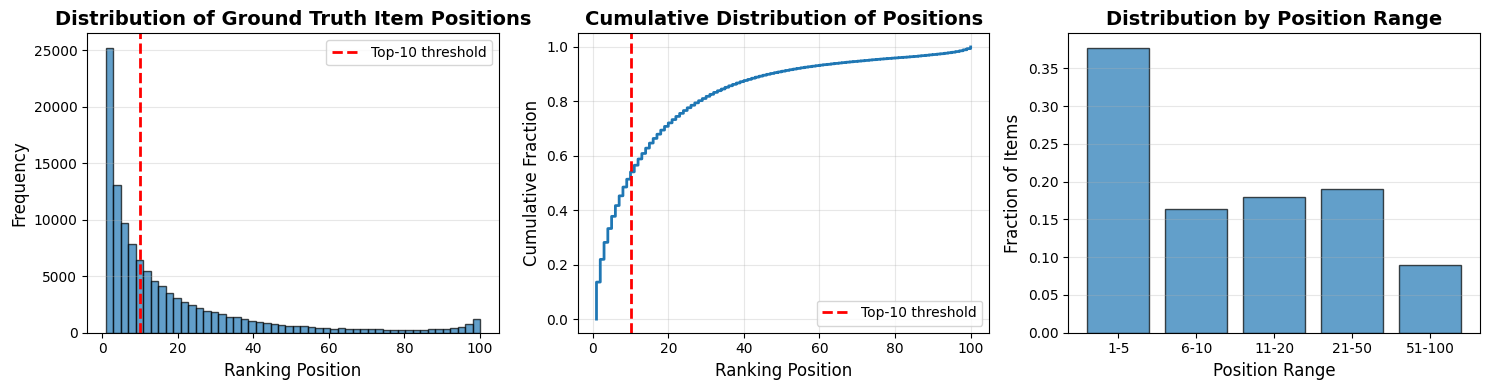


RANKING STATISTICS
Total test samples: 115056
Items in top-10: 62214 (54.07%)
Mean position: 17.76
Median position: 9.00
Items in top-5: 43427 (37.74%)
Items in top-20: 82933 (72.08%)


In [15]:
# Analyze ranking positions across all test samples
model.eval()
# Use the pre-computed tensor from training (or create if not available)
if 'train_mat_tensor' not in globals():
    print("Creating training matrix tensor...")
    train_mat_tensor = torch.FloatTensor(train_mat.toarray()).to(device)

print("Analyzing ranking positions...")

all_positions = []
all_hits = []

with torch.no_grad():
    for batch_idx, (user, item, label) in enumerate(tqdm(test_loader, desc="Processing", leave=False)):
        user = user.to(device)
        item = item.to(device)
        
        u = user[0].item()
        batch_size = item.shape[0]
        
        # OPTIMIZED: Batch reconstruction
        item_vectors = train_mat_tensor[:, item].T  # Shape: (batch_size, num_users)
        reconstructed_batch = model(item_vectors)  # Shape: (batch_size, num_users)
        predictions = reconstructed_batch[:, u]  # Extract user's scores
        
        # Create item scores list
        item_scores = [(item[idx].item(), predictions[idx].item(), idx == 0) 
                       for idx in range(batch_size)]
        
        # Sort by score
        item_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Find position of ground truth (first item in batch)
        gt_item = item[0].item()
        gt_position = next((i for i, (item_id, _, _) in enumerate(item_scores) if item_id == gt_item), -1)
        
        if gt_position >= 0:
            all_positions.append(gt_position + 1)  # 1-indexed
            all_hits.append(1 if gt_position < TOP_K else 0)

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Position distribution (histogram)
axes[0].hist(all_positions, bins=min(50, max(all_positions)), edgecolor='black', alpha=0.7)
axes[0].axvline(x=TOP_K, color='r', linestyle='--', linewidth=2, label=f'Top-{TOP_K} threshold')
axes[0].set_xlabel('Ranking Position', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Ground Truth Item Positions', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Cumulative distribution
sorted_positions = sorted(all_positions)
cumulative = np.arange(1, len(sorted_positions) + 1) / len(sorted_positions)
axes[1].plot(sorted_positions, cumulative, linewidth=2)
axes[1].axvline(x=TOP_K, color='r', linestyle='--', linewidth=2, label=f'Top-{TOP_K} threshold')
axes[1].set_xlabel('Ranking Position', fontsize=12)
axes[1].set_ylabel('Cumulative Fraction', fontsize=12)
axes[1].set_title('Cumulative Distribution of Positions', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Hit rate by position range
position_ranges = [(1, 5), (6, 10), (11, 20), (21, 50), (51, 100)]
range_labels = ['1-5', '6-10', '11-20', '21-50', '51-100']
hit_rates_by_range = []

for start, end in position_ranges:
    in_range = [1 if start <= pos <= end else 0 for pos in all_positions]
    hit_rates_by_range.append(np.mean(in_range) if in_range else 0)

axes[2].bar(range_labels, hit_rates_by_range, alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Position Range', fontsize=12)
axes[2].set_ylabel('Fraction of Items', fontsize=12)
axes[2].set_title('Distribution by Position Range', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save figure
plt.savefig(os.path.join(MODEL_PATH, 'autorec_ranking_analysis.png'), dpi=150, bbox_inches='tight')
print(f"✓ Saved ranking analysis to {os.path.join(MODEL_PATH, 'autorec_ranking_analysis.png')}")

plt.show()

# Print statistics
print("\n" + "=" * 70)
print("RANKING STATISTICS")
print("=" * 70)
print(f"Total test samples: {len(all_positions)}")
print(f"Items in top-{TOP_K}: {sum(all_hits)} ({np.mean(all_hits)*100:.2f}%)")
print(f"Mean position: {np.mean(all_positions):.2f}")
print(f"Median position: {np.median(all_positions):.2f}")
print(f"Items in top-5: {sum(1 for p in all_positions if p <= 5)} ({sum(1 for p in all_positions if p <= 5)/len(all_positions)*100:.2f}%)")
print(f"Items in top-20: {sum(1 for p in all_positions if p <= 20)} ({sum(1 for p in all_positions if p <= 20)/len(all_positions)*100:.2f}%)")
print("=" * 70)

## Step 10: Summary

### Key Results

Results will be displayed in the cell below after training completes.

### Model Architecture

- **Type**: Item-based AutoRec (I-AutoRec) for Implicit Feedback
- **Hidden Units**: 500
- **Loss Function**: BCEWithLogitsLoss with L2 regularization
- **Optimizer**: Adam (lr=0.001)

### Training Details

- **Max Epochs**: 50
- **Early Stopping**: 10 epochs patience
- **Negative Sampling**: 4 negatives per positive (training)
- **Test Negatives**: 99 negatives per positive (evaluation)
- **Regularization**: λ = 0.001

In [16]:
# Print final summary
print("=" * 70)
print("TRAINING SUMMARY")
print("=" * 70)
print(f"Best HR@{TOP_K}: {best_hr:.6f}")
print(f"Best NDCG@{TOP_K}: {best_ndcg:.6f}")
print(f"Final HR@{TOP_K}: {final_hr:.6f}")
print(f"Final NDCG@{TOP_K}: {final_ndcg:.6f}")
print(f"Total Epochs Trained: {len(history['loss'])}")
print(f"Regularization (λ): {LAMBDA_REG}")
print(f"Negative Sampling (Training): {NUM_NG} negatives per positive")
print(f"Test Negatives: {TEST_NUM_NG} negatives per positive")
print("=" * 70)

TRAINING SUMMARY
Best HR@10: 0.540728
Best NDCG@10: 0.311600
Final HR@10: 0.540728
Final NDCG@10: 0.311600
Total Epochs Trained: 11
Regularization (λ): 0.001
Negative Sampling (Training): 4 negatives per positive
Test Negatives: 99 negatives per positive


## Notes

### Differences from Rating Prediction

| Aspect | Rating Prediction | Ranking (Implicit) |
|--------|------------------|-------------------|
| **Data** | Actual ratings (1-5) | Binary (1 = positive, 0 = negative) |
| **Loss** | MSE | BCEWithLogitsLoss |
| **Sampling** | No negative sampling | Negative sampling (NUM_NG=4) |
| **Metrics** | RMSE, MAE | HR@K, NDCG@K |
| **Output** | Rating value [1, 5] | Interaction score (logit) |

### Evaluation Protocol

- Each test sample contains: 1 positive item + 99 negative items
- Model predicts scores for all 100 items
- Top-K items are selected based on predicted scores
- HR@K = 1 if positive item is in top-K, else 0
- NDCG@K considers the position of the positive item in top-K